In [1]:
import numpy
print(numpy.__version__)
import networkx
print(networkx.__version__)

from nilmtk.api import API
import warnings

warnings.filterwarnings("ignore")
from nilmtk.disaggregate import GaterCNN, DM_GATE2
import nilmtk.utils as utils

1.24.3
2.8.4


c:\ProgramData\Anaconda3\envs\py310\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
# import pytorch_lightning as pl

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

# from src import *

USE_GPU = True
device = torch.device("cuda:0" if USE_GPU and torch.cuda.is_available() else "cpu")
print(torch.__version__, device)

2.0.1 cuda:0


DM_GATE2
............... Loading Data for training ...................
Loading data for  redd  dataset
Loading building ...  3
Loading data for meter ElecMeterID(instance=1, building=3, dataset='REDD')     {'fill_method': None, 'how': 'mean'}
Loading data for meter ElecMeterID(instance=2, building=3, dataset='REDD')     {'fill_method': None, 'how': 'mean'}

Done loading data all meters for this chunk.
{'fill_method': None, 'how': 'mean'}
Dropping missing values
Train Jointly
...............SGN partial_fit running...............
Found dataset info, skipped loading training data
First model training for  microwave
Started training for  DM_GATE2
Joint training for  DM_GATE2
............... Loading Data for training ...................
Loading data for  redd  dataset
Loading building ...  3
Loading data for meter ElecMeterID(instance=1, building=3, dataset='REDD')     {'fill_method': None, 'how': 'mean'}
Loading data for meter ElecMeterID(instance=2, building=3, dataset='REDD')     {'fill_

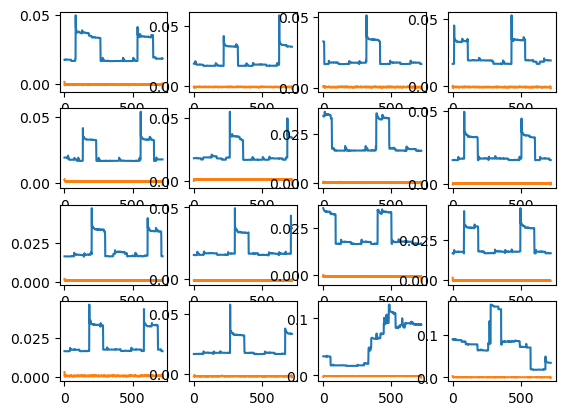

Inference Time consumption: 4.185370922088623s.
microwave prediction done, computing results
length 156815 156815 156815


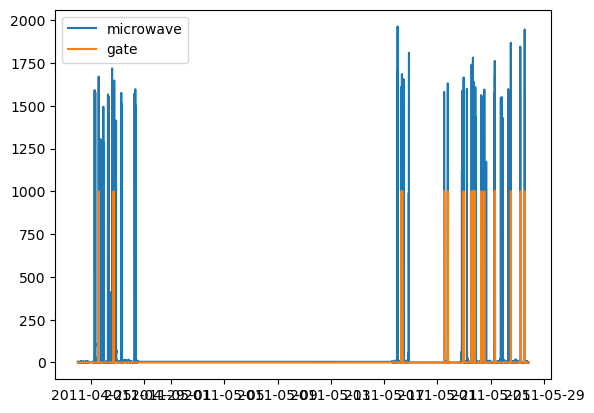

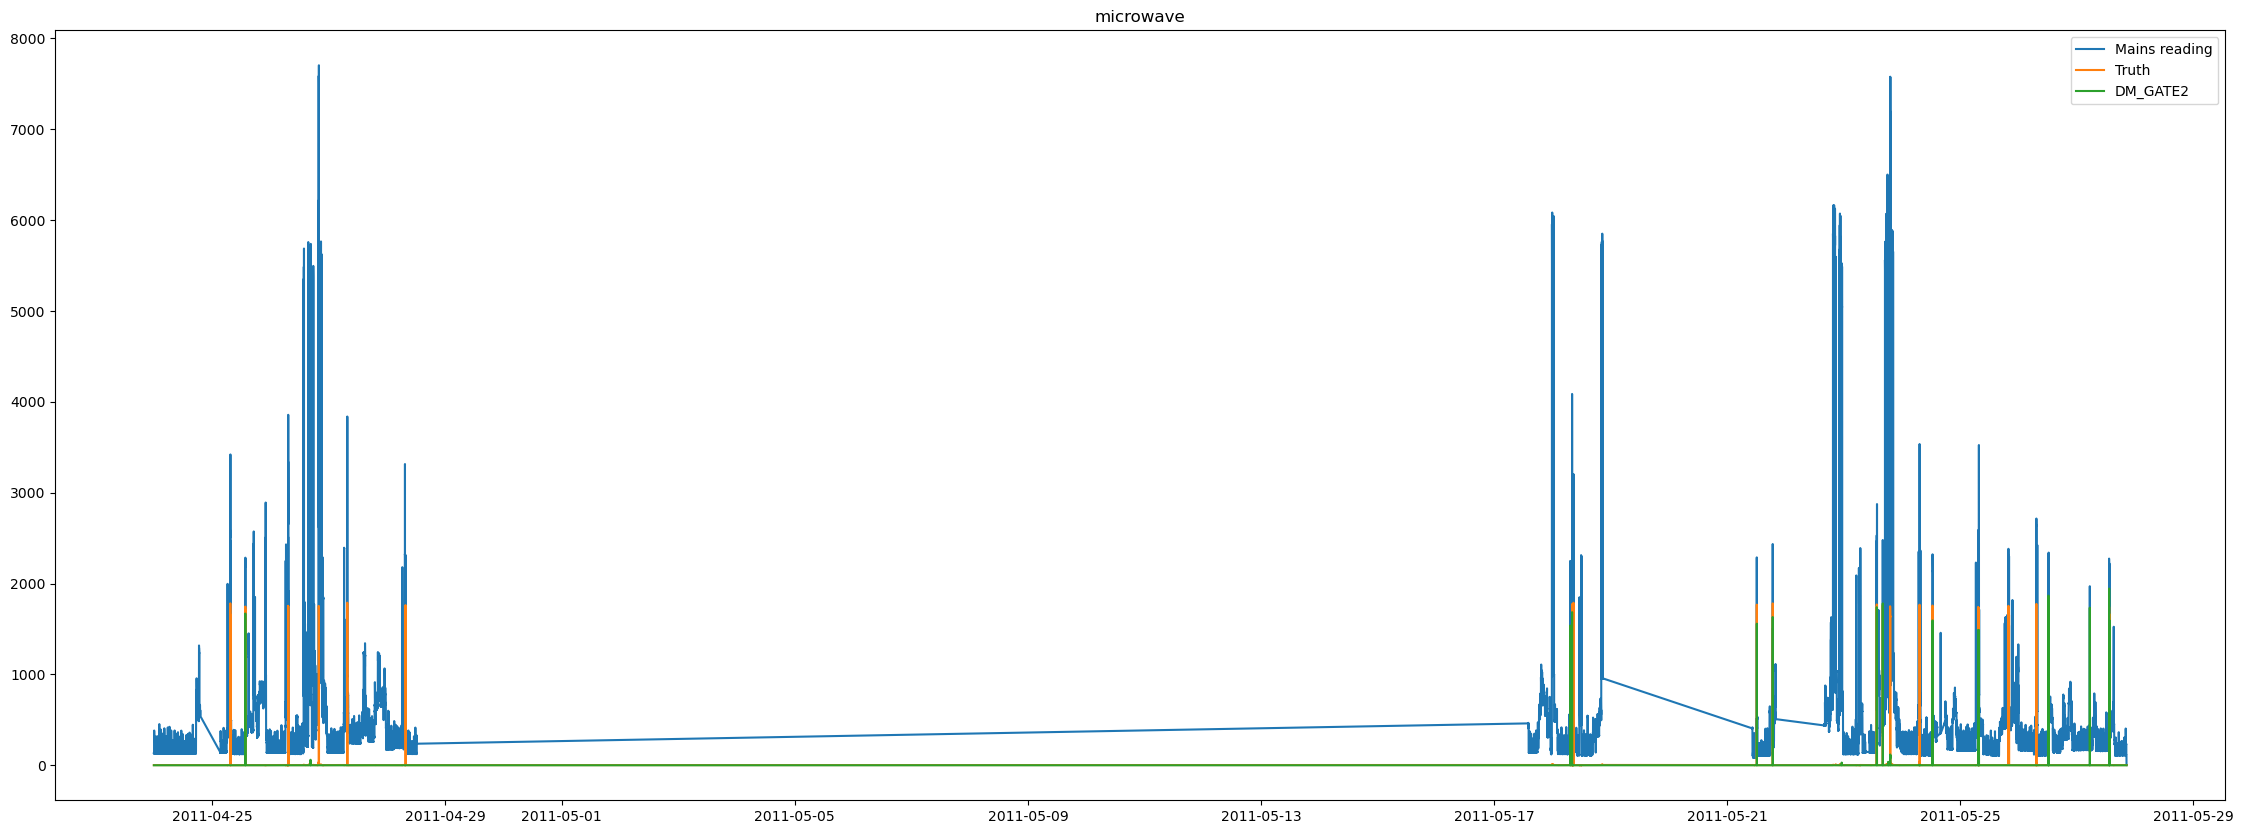

............  accuracy  ..............
           DM_GATE2
microwave  0.996269
............  f1score  ..............
           DM_GATE2
microwave  0.285714
............  mae  ..............
           DM_GATE2
microwave  8.325062
sae with ws {'window_size': 600}
............  sae  ..............
           DM_GATE2
microwave   7.72965
............  ssim  ..............
           DM_GATE2
microwave  0.979456
............  wssim  ..............
           DM_GATE2
microwave  0.092651


In [3]:
DATASET_NAME = 'redd'
HOUSE = 3
TUNED_SGN = False
TUNE = False
APPLIANCE = "microwave"

days = 1

CSV_PATH = f"./csv_ft/{days}days_{APPLIANCE}_{HOUSE}_GATE={TUNED_SGN}_DM={TUNE}.csv"
MODEL_NOTE = f"{days}days_ft_{HOUSE}"
if TUNED_SGN:
    # GATER_PATH = f"./{days}days_{APPLIANCE}_ft_{HOUSE}_sgn_best_state_dict.pt"
    GATER_PATH = f"./{APPLIANCE}_ft_{HOUSE}_sgn_best_state_dict.pt"
else:
    GATER_PATH = f"./{APPLIANCE}_ukdale_sgn_best_state_dict.pt"

if HOUSE == 1:
    TRAIN = {
        # 1: {
        #     'start_time': '2011-04-19',
        #     'end_time': '2011-04-26'
        # },
        1: {
            'start_time': '2011-04-23',
            'end_time': '2011-04-24'
        },
    }
    TEST = {
        1: {
            'start_time': '2011-04-24',
            'end_time': '2011-05-26'
        },
    }
elif HOUSE == 2:
    TRAIN = {
        # 2: {
        #     'start_time': '2011-04-18',
        #     'end_time': '2011-04-25'
        # },
        2: {  # for DW
            'start_time': '2011-04-18',
            'end_time': '2011-04-19'
        },
        # 2: {  # for WM
        #     'start_time': '2011-04-23',
        #     'end_time': '2011-04-24'
        # },
    }
    TEST = {
        2: {
            'start_time': '2011-04-25',
            'end_time': '2011-05-22'
        },
    }
elif HOUSE == 3:
    TRAIN = {
        # 3: {
        #     'start_time': '2011-04-17',
        #     'end_time': '2011-04-24'
        # },
        3: {  # for D.W.
            'start_time': '2011-04-17',
            'end_time': '2011-04-18'
        },
        # 3: {  # for W.M.
        #     'start_time': '2011-04-19',
        #     'end_time': '2011-04-20'
        # },
    }
    TEST = {
        3: {
            'start_time': '2011-04-24',
            'end_time': '2011-05-30'
        },
    }
else:
    raise NameError

e = {
    # Specify power type, sample rate and disaggregated appliance
    'power': {
        'mains_train': ['apparent'],
        'mains_transfer': ['apparent'],
        'mains_test': ['apparent'],
                
        # 'appliance': ['active']
        # 'mains': ['apparent'],  # problem: ukdale active, redd apparent
        'appliance': ['active'],
    },
    'sample_rate': 6,
    'appliances': [APPLIANCE],
    # 'appliances': ['dish washer'],
    # Universally no pre-training
    'pre_trained': False,
    "app_meta": utils.GENERAL_APP_META,
    # Specify algorithm hyper-parameters
    'gater': 
        GaterCNN({'n_epochs': 0, 'batch_size': 64, 'test_only': True, 'note': '', 
             'load_path': GATER_PATH})
    ,
    'csv_path': CSV_PATH,
    'methods': {
        "DM_GATE2": DM_GATE2(
            {'n_epochs': 5, 'batch_size': 16, 'sequence_length': 720, 'overlapping_step': 1,
            'test_only': True, 'fine_tune': TUNE, 'src_rate': 0.0, 'lr': 5e-6, "sampler": "ddim", "patience": 3,
            'freeze': True,
            "app_meta": utils.GENERAL_APP_META, 'filter_train': True, 'note': MODEL_NOTE, 'load_from': 'ukdale'})
         },
    # Specify train and test data
    'train': {
        'datasets': {
            # 'ukdale': {
            #     'path': 'mnt/ukdale.h5',
            #     'buildings': {
            #         1: {
            #             'start_time': '2013-05-31',
            #             'end_time': '2013-08-31'
            #         },
            #         5: {
            #             'start_time': '2014-07-01',
            #             'end_time': '2014-09-05'
            #         },
            #     }
            # },
            'redd': {
                'path': 'mnt/redd.h5',
                'buildings': TRAIN.copy()
            },
        }
    },
    'transfer': {
        'datasets': {
            'redd': {
                'path': 'mnt/redd.h5',
                'buildings': TRAIN.copy()
            },
        },
    },
    'test': {
        'datasets': {
            'redd': {
                'path': 'mnt/redd.h5',
                'buildings': TEST.copy()
            },
        },
        # Specify evaluation metrics
        'metrics': ['accuracy', 'f1score', 'mae', 'sae', 'ssim', 'wssim']
    }
}

API(e)